#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
import numpy as np
import time
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
import warnings
warnings.filterwarnings('ignore')
from pylab import rcParams
rcParams['figure.figsize'] = 16, 6

In [2]:
def data_read_glance(file_path):# создаем функцию для загрузки данных и первичного анализа. На вход принимает путь до файла.
    data = pd.read_csv(file_path, parse_dates= [0], index_col=[0])
    print(data.info())
    return data
df = data_read_glance('C:/Users/VovAz/Desktop/Проект/Временные ряды/taxi.csv')


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
None


Данные прочитаны, пропусков нет, тип данных соответствует описанию.

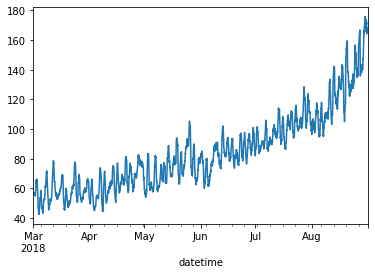

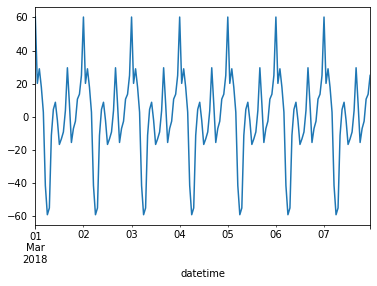

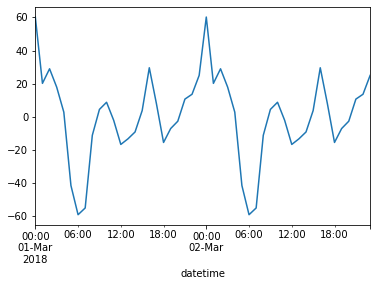

<AxesSubplot:xlabel='datetime'>

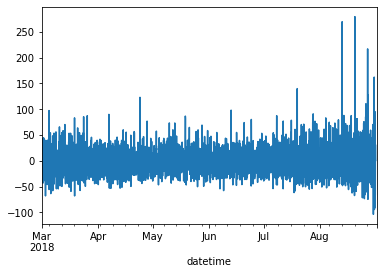

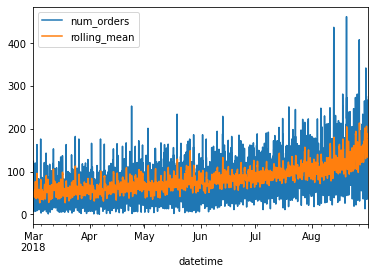

In [3]:
df.sort_index(inplace=True)
df = df.resample('1h').sum()
decomposed = seasonal_decompose(df)
decomposed.trend.plot()
plt.show()
decomposed.seasonal['2018-03-01': '2018-03-07'].plot()
plt.show()
decomposed.seasonal['2018-03-01': '2018-03-02'].plot()
plt.show()
decomposed.resid.plot() 
df['rolling_mean'] = df.rolling(10).mean() 
df.plot()


Рессемплируем данные по одному часу
Изучим тренды и сезонность.
График сезонности демонстрирует повышения среднего числа заказов на протяжении марта-августа.
Тренды отражают часовые колебания среднего числа заказов - минимум в 6ть утра, пики в конче рабочего дня и в полночь.
Также присуствует большое количество шумов, которые нельзя оъяснить трендами или сезонностью.
Изучим график заказов такси и изобразим скользящее среднее за 10 часов. Наблюдается увеличение среднего числа заказов.
Необходимо проверить, является ли временной ряд стацинарным.

## Анализ

In [4]:
X = df['num_orders'].values
res = adfuller(X)
print('Критическое значение теста: {}'.format(res[0]))
print('p-value: {}'.format(res[1]))
print('Значения с учетом различного доверительного интервала:')
for key, value in res[4].items():
    print('\t{}: {:.3f}'.format(key, value))

if res[0] < res[4]["5%"]:#используем 5% доверительный интервал
    print ("Отвергаем нулевую гипотезу - Временной ряд станционарный")
else:
    print ("Не получилось отвергнеть нулевую гипотезу - Временной ряд нестанционарный")

Критическое значение теста: -3.0689242890279527
p-value: 0.02894005140261315
Значения с учетом различного доверительного интервала:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Отвергаем нулевую гипотезу - Временной ряд станционарный


С помощью теста Дики-Фуллера узнаем с какой веростностью ряд является нестационарным. Критическое значение теста - меньше значения т-теста с 5% доверительным интервалом. Вероятность того, что ряд нестационарный - 2,9%.
Приступим к обучению моделей предсказания.

## Обучение

In [5]:
def make_features(data, max_lag, rolling_mean_size):#создаем фнция для создания признаков, на вход принимает датасет<
#>, количество столбцов с лагом и размер окна среднего скользящего значения.
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [6]:
random_state = 12345
models = [DecisionTreeRegressor(random_state = random_state), 
          RandomForestRegressor(random_state=random_state), 
          LinearRegression(), CatBoostRegressor(random_state=random_state,  verbose=False),LGBMRegressor(random_state=random_state) ]


results = []
for lag in range(1, 25):
    for roll in range(1,25):
        make_features(df, lag, roll)
        train, test = train_test_split(df, shuffle=False, test_size=0.1, random_state = random_state )
        train = train.dropna()
        features_train = train.drop(['num_orders'], axis = 1)
        target_train = train['num_orders']
        features_test = test.drop(['num_orders'], axis = 1)
        target_test = test['num_orders']

        for model in models:     
    
            train_start = time.time()
            model.fit(features_train, target_train)
            pred = model.predict(features_test)
            score = mean_squared_error(target_test, pred) ** 0.5

            train_end = time.time()
            results.append({'model_name': model.__class__.__name__, 
                              'rmse': score, 
                              'training time': train_end - train_start,
                            'max_lag': lag,
                            'rolling_mean_size':roll
                              })  
              
res = pd.DataFrame(results)
res

,model_name,rmse,training time,max_lag,rolling_mean_size
0,DecisionTreeRegressor,73.072506,0.014000,1,1
1,RandomForestRegressor,58.011000,0.662044,1,1
2,LinearRegression,57.587249,0.003954,1,1
3,CatBoostRegressor,57.430159,1.527997,1,1
4,LGBMRegressor,55.748730,0.049999,1,1
...,...,...,...,...,...
2875,DecisionTreeRegressor,63.467364,0.124012,24,24
2876,RandomForestRegressor,44.099079,5.440969,24,24
2877,LinearRegression,45.178107,0.004990,24,24
2878,CatBoostRegressor,39.904454,5.719306,24,24


<AxesSubplot:xlabel='max_lag'>

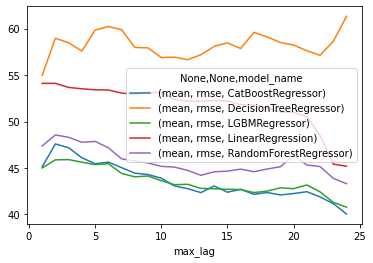

In [7]:
pivot_lag = res.pivot_table(index=['max_lag'], 
                                                          columns=['model_name'],
                                                          values=['rmse'],
                                                          aggfunc=['mean'])
pivot_lag.plot()

<AxesSubplot:xlabel='rolling_mean_size'>

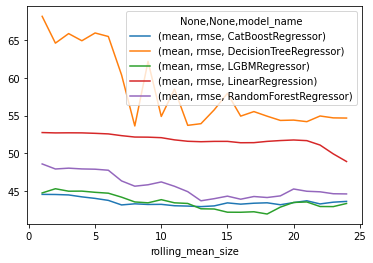

In [8]:
pivot_rolling = res.pivot_table(index=['rolling_mean_size'], 
                                                          columns=['model_name'],
                                                          values=['rmse'],
                                                          aggfunc=['mean'])
pivot_rolling.plot()

<AxesSubplot:xlabel='rolling_mean_size'>

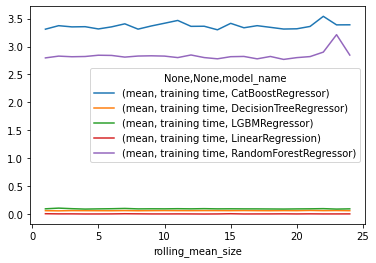

In [9]:
pivot_rolling = res.pivot_table(index=['rolling_mean_size'], 
                                                          columns=['model_name'],
                                                          values=['training time'],
                                                          aggfunc=['mean'])
pivot_rolling.plot()

<AxesSubplot:xlabel='max_lag'>

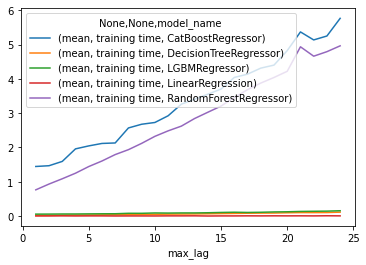

In [10]:
pivot_rolling = res.pivot_table(index=['max_lag'], 
                                                          columns=['model_name'],
                                                          values=['training time'],
                                                          aggfunc=['mean'])
pivot_rolling.plot()

Изучив графики средних значений rmse для различных моделей для различных параметров создания признаков, делаем вывод что все представленные модели показали себя хорошо, кроме дерева решения. Количество столбцов с лагом оказывает положительное влияние на rmse, размер окна среднего скользящего не оказывает значительного влияния на rmse.

In [11]:
make_features(df, 24, 24)
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()
features_train = train.drop(['num_orders'], axis = 1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis = 1)
target_test = test['num_orders']
tscv = TimeSeriesSplit(n_splits=24)

In [12]:
train_start = time.time()
model = RandomForestRegressor() 
hyperparams = [{'n_estimators' : [x for x in range(1, 10)], 
                'max_depth':[x for x in range(1, 20)], 
                'random_state':[123456]}]

clf = GridSearchCV(model, hyperparams,cv =tscv, scoring='neg_root_mean_squared_error')
clf.fit(features_train, target_train)
print("Лучшие гиперпараметры модели:")

print(clf.best_params_)
train_end = time.time()
print('Время подбора гиперпараметров:{}'.format(train_end - train_start))

Лучшие гиперпараметры модели:
{'max_depth': 13, 'n_estimators': 9, 'random_state': 123456}
Время подбора гиперпараметров:356.05990839004517


In [13]:
train_start = time.time()
model = LGBMRegressor() 

hyperparams = [{'num_leaves' : [x for x in range(1, 102, 20)], 
                'max_depth':[x for x in range(1, 12, 2)],
                'random_state':[123456]}]


clf = GridSearchCV(model, hyperparams,cv =tscv, scoring='neg_root_mean_squared_error')
clf.fit(features_train, target_train)
print("Лучшие гиперпараметры модели:")

print(clf.best_params_)
train_end = time.time()
print('Время подбора гиперпараметров:{}'.format(train_end - train_start))

Лучшие гиперпараметры модели:
{'max_depth': 9, 'num_leaves': 21, 'random_state': 123456}
Время подбора гиперпараметров:57.28786563873291


In [14]:
train_start = time.time()
model = CatBoostRegressor() 

hyperparams = [{'learning_rate':[0.1,  0.5, 0.9],
                'depth':[x for x in range(1, 11, 3)],
                'random_state':[123456], 'verbose': [False]}]


clf = GridSearchCV(model, hyperparams,cv =tscv, scoring='neg_root_mean_squared_error')
clf.fit(features_train, target_train)
print("Лучшие гиперпараметры модели:")

print(clf.best_params_)
train_end = time.time()
print('Время подбора гиперпараметров:{}'.format(train_end - train_start))

Лучшие гиперпараметры модели:
{'depth': 7, 'learning_rate': 0.1, 'random_state': 123456, 'verbose': False}
Время подбора гиперпараметров:5413.962451696396


Подобрали лучшие гиперпараметры выбранных моделей.

## Тестирование

In [16]:
models = [RandomForestRegressor(max_depth = 13, n_estimators = 9, random_state = 123456), 
          CatBoostRegressor(depth = 7, learning_rate = 0.1, random_state= 123456, verbose=False),
          LGBMRegressor(max_depth= 9, num_leaves = 21, random_state= 123456), LinearRegression()]


results = []

for model in models: 
    train_start = time.time()  
    model.fit(features_train, target_train)
    train_end = time.time()
    predict_start = time.time()
    pred = model.predict(features_test)
    predict_end = time.time()
    rmse = mean_squared_error(target_test, pred)**0.5
    results.append({'model_name': model.__class__.__name__, 
                    'training time': train_end - train_start,
                    'prediction time': predict_end - predict_start,
                    'rmse': rmse                              
                              })  
              
res = pd.DataFrame(results)
res

,model_name,training time,prediction time,rmse
0,RandomForestRegressor,0.426000,0.003000,44.683585
1,CatBoostRegressor,9.972008,0.002995,41.318265
2,LGBMRegressor,0.102998,0.004001,42.326402
3,LinearRegression,0.005000,0.001999,45.178107


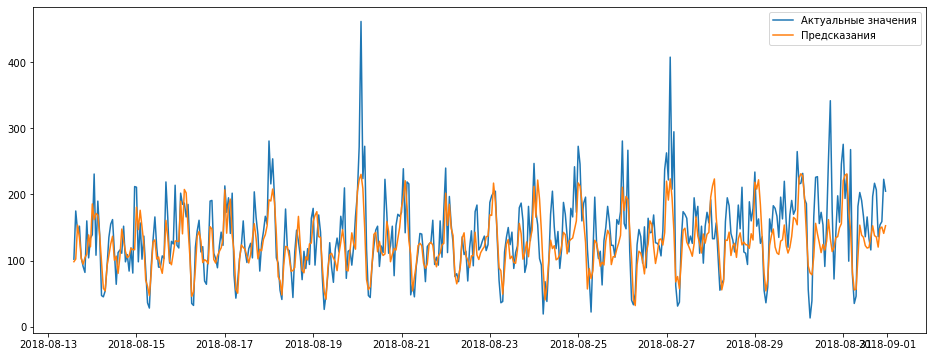

In [21]:
model = LGBMRegressor(max_depth= 9, num_leaves = 21, random_state= 123456)
model.fit(features_train, target_train)
pred = model.predict(features_test)
plt.plot(features_test.index, target_test, label='Актуальные значения')
plt.plot(features_test.index, pred, label='Предсказания')
plt.legend()
plt.show()

Все модели показали себя хорошо на тестовой выборке. Линейная регрессия практически мгновенно обучается и предсказывает и показывает результат, сопоставимый с рандомным лесом. LGBM обучается и предсказывает намного быстрее, чем рандомный лес, при этом rmse составляет 42.3 против 44.7. CatBoost показывает rmse немногим лучший, чем у LGBM, при этом тратит на несколько порядков больше времен на обучение. Оптимальным вариантом для использования на практике можно назвать LGBM. Построили график расхождения актуальных значений и предсказаний. Модель хорошо пресказывает общее направление тренда, однако не в силах предсказать выбросы.